У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
cd /content/drive/MyDrive/ML course/data

/content/drive/MyDrive/ML course/data


In [122]:
#!unzip "train.csv.zip"

In [123]:
data = pd.read_csv('train.csv')

In [124]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [125]:
data[:10]

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [126]:
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [128]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



Побудую boxplot, який покаже продажі по магазинах, з візуалізацією середніх продаж, викидів та IQR по продажах

<Figure size 1200x600 with 0 Axes>

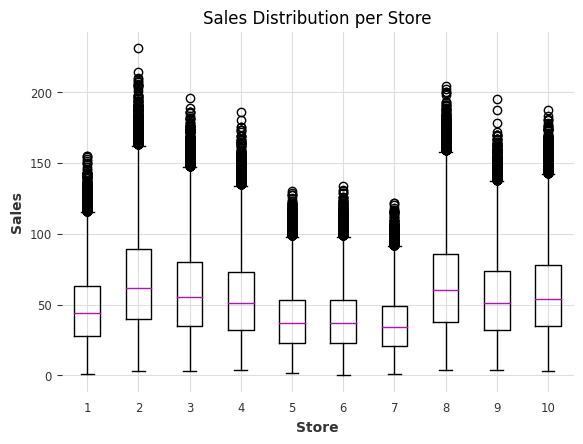

In [129]:
plt.figure(figsize=(12, 6))
data.boxplot(column='sales', by='store')
plt.title('Sales Distribution per Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.suptitle('')  # Видалити дублюючий заголовок
plt.show()


Судячи по цьому боксплоту видно, що найкраще продажі йдуть у магазинах 2, 3, 8, 10.
Вони показуть найкращі середні продажі та найбільший діапазон IQR

Цей scatterplot показує середні продажі кожного товару по магазинах

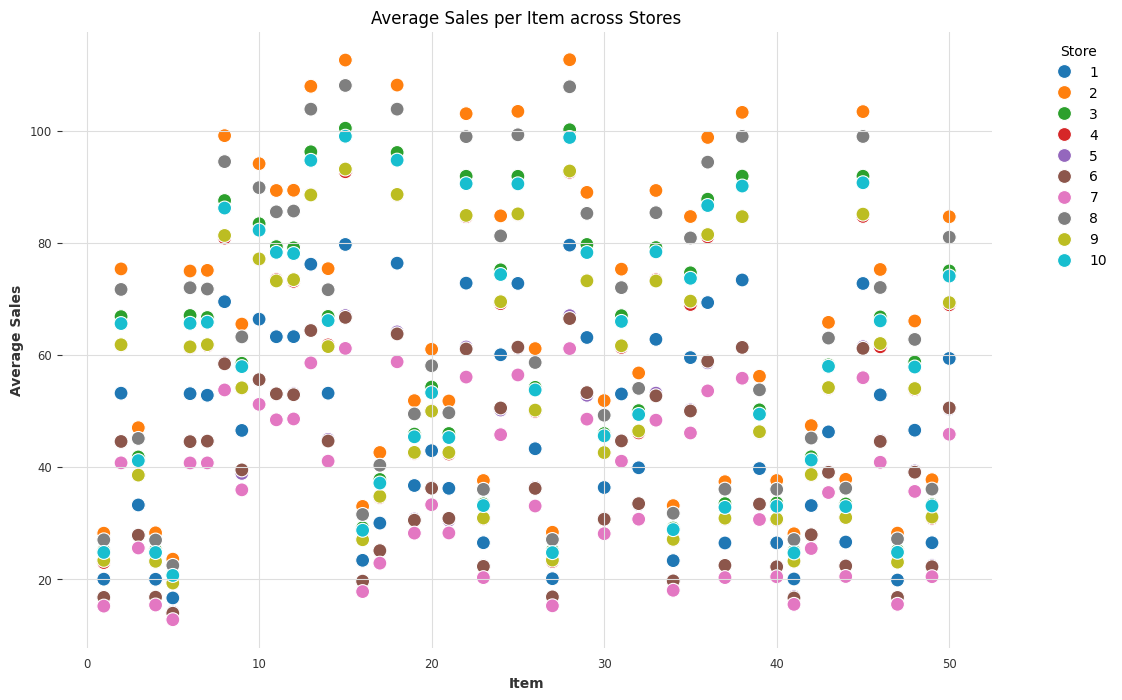

In [130]:
mean_sales = data.groupby(['store', 'item'])['sales'].mean().reset_index()

# Побудова scatterplot для середніх продажів
plt.figure(figsize=(12, 8))
sns.scatterplot(data=mean_sales, x='item', y='sales', hue='store', palette='tab10', s=100)
plt.title('Average Sales per Item across Stores')
plt.xlabel('Item')
plt.ylabel('Average Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Зі скатерплоту теж видно, що по середніх продажах лідирують 2, 3, 8, 10 магазини.
Найменші середні продажі показують 7 та 6 магазини

Боксплот по продажу кожного товару по магазинах. Вивів на 2 графіки для кращої читабельності.

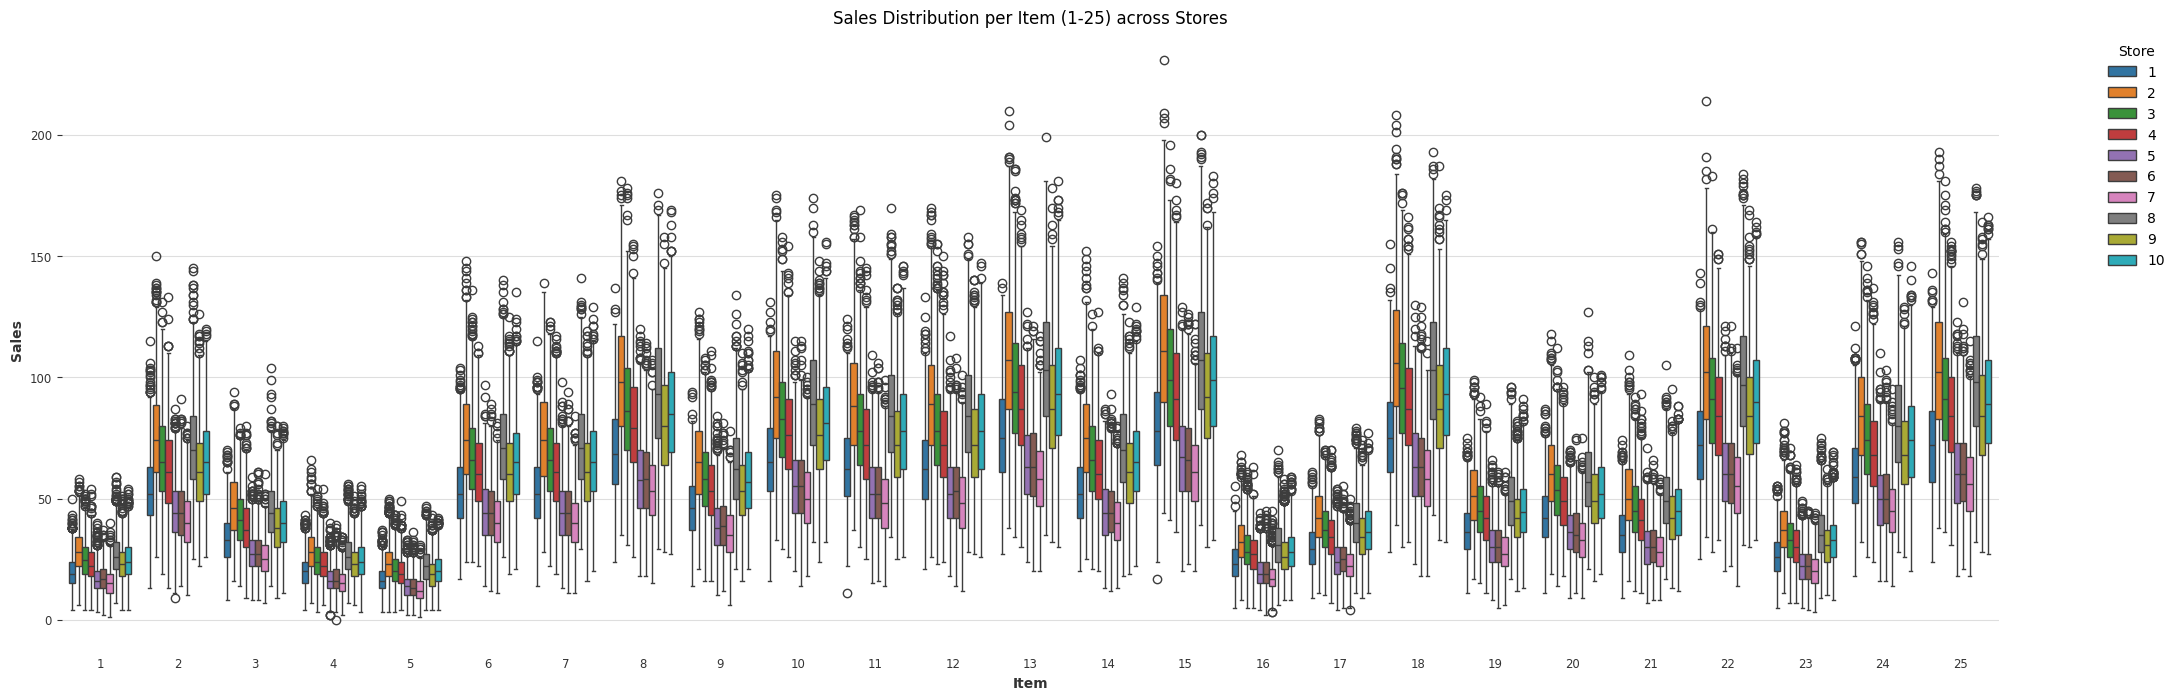

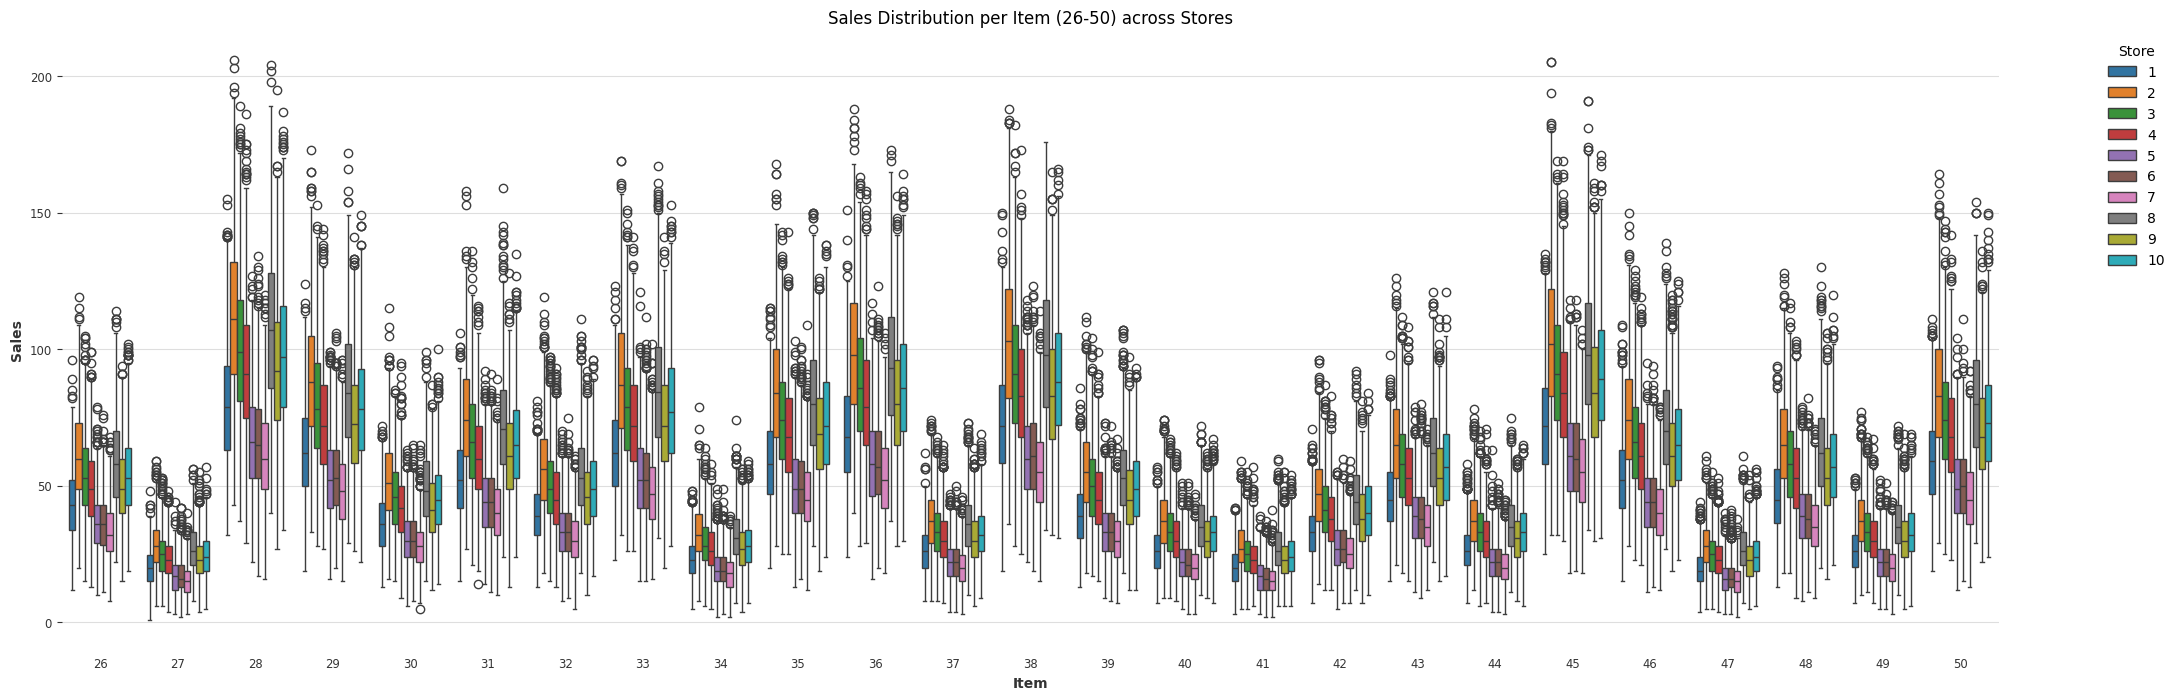

In [131]:
# Фільтрація даних для кожного діапазону item_id
data_1_25 = data[(data['item'] >= 1) & (data['item'] <= 25)]
data_26_50 = data[(data['item'] >= 26) & (data['item'] <= 50)]


# Побудова графіку для item_id 1-25
plt.figure(figsize=(25, 8))
sns.boxplot(data=data_1_25, x='item', y='sales', hue='store', palette='tab10')
plt.title('Sales Distribution per Item (1-25) across Stores')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Побудова графіку для item_id 26-50
plt.figure(figsize=(25, 8))
sns.boxplot(data=data_26_50, x='item', y='sales', hue='store', palette='tab10')
plt.title('Sales Distribution per Item (26-50) across Stores')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




<ipython-input-132-f34d2ef56463>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='item', y='sales', palette='tab10')


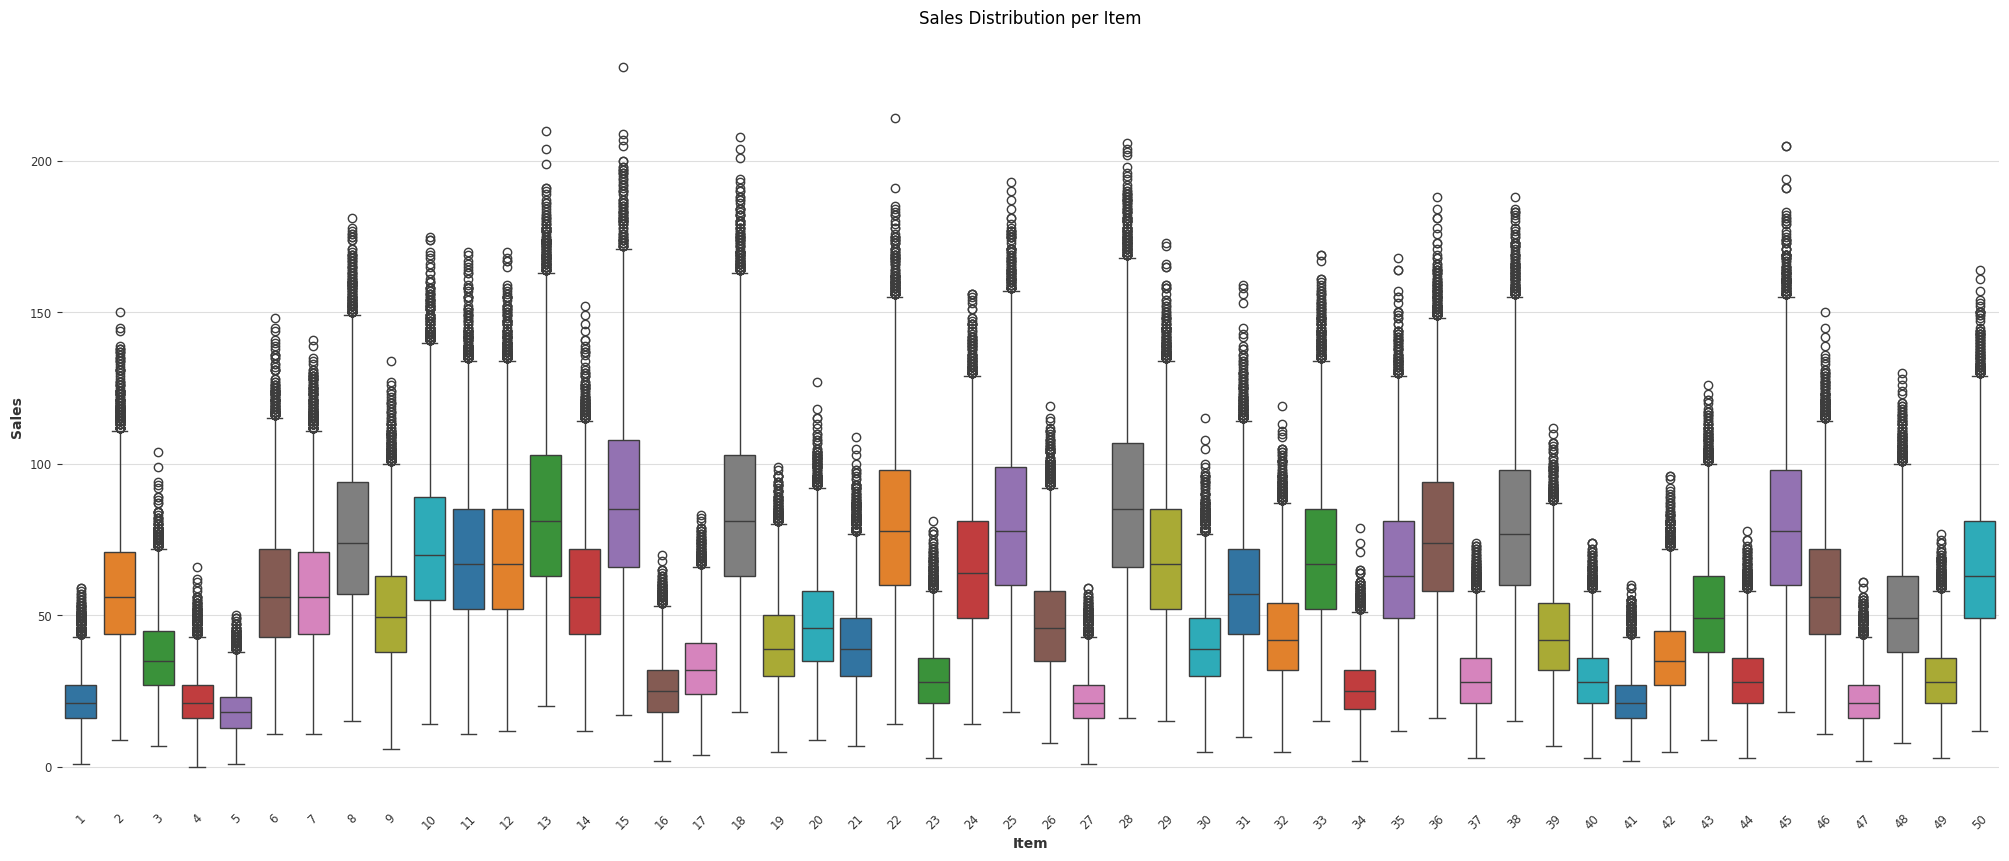

In [132]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=data, x='item', y='sales', palette='tab10')
plt.title('Sales Distribution per Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Обертання міток на осі X для кращої читабельності
plt.show()

На цьому боксплоті можна побачити лідерів продаж, проте через велику кількість товарів, краще розглядати у парі з таблицею у якій вивести топ-10 товарів, які продаються, та топ 10, які найгірше продаються


In [133]:
# Групування даних за 'item' і обчислення середніх продажів для кожного айтему
item_sales_avg = data.groupby('item')['sales'].mean().reset_index()

# Сортування айтемів за середніми продажами в порядку спадання
item_sales_sorted = item_sales_avg.sort_values(by='sales', ascending=False)

# Вибір топ-10 товарів з найкращим середнім продажем
top_10_best_selling = item_sales_sorted.head(10)

# Вибір топ-10 товарів з найгіршим середнім продажем
top_10_worst_selling = item_sales_sorted.tail(10)

# Об'єднання двох таблиць для зручності
top_10_combined = pd.concat([top_10_best_selling, top_10_worst_selling], axis=0)

print("\nОб'єднана таблиця топ-10 найкращих та найгірших товарів за середніми продажами:")
print(top_10_combined)



Об'єднана таблиця топ-10 найкращих та найгірших товарів за середніми продажами:
    item      sales
14    15  88.030778
27    28  87.881325
12    13  84.316594
17    18  84.275794
24    25  80.686418
44    45  80.584173
37    38  80.521906
21    22  80.502245
35    36  77.028916
7      8  76.950055
36    37  29.258379
39    40  29.249398
33    34  25.735761
15    16  25.656079
26    27  22.049726
3      4  22.010241
46    47  22.003341
40    41  22.002136
0      1  21.981599
4      5  18.358708


3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [134]:
data_i1_s1 = data[(data['item'] == 1) & (data['store'] == 1)]

In [135]:
df_i1_s1_additive = data_i1_s1.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 50
df_i1_s1_additive["trend"] = df_i1_s1_additive["sales"].rolling(window=365, center=True).mean()

# віднімаємо тренд з даних
df_i1_s1_additive["detrended"] = df_i1_s1_additive["sales"] - df_i1_s1_additive["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_i1_s1_additive["month"] = df_i1_s1_additive.index.month
df_i1_s1_additive["seasonality"] = df_i1_s1_additive.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_i1_s1_additive["resid"] = df_i1_s1_additive["detrended"] - df_i1_s1_additive["seasonality"]

# що у нас вийшло в результаті
df_i1_s1_additive.head(10)

,store,item,sales,trend,detrended,month,seasonality,resid
date,,,,,,,,
2013-01-01,1,1,13,NaN,NaN,1,-5.706695,NaN
2013-01-02,1,1,11,NaN,NaN,1,-5.706695,NaN
2013-01-03,1,1,14,NaN,NaN,1,-5.706695,NaN
2013-01-04,1,1,13,NaN,NaN,1,-5.706695,NaN
2013-01-05,1,1,10,NaN,NaN,1,-5.706695,NaN
2013-01-06,1,1,12,NaN,NaN,1,-5.706695,NaN
2013-01-07,1,1,10,NaN,NaN,1,-5.706695,NaN
2013-01-08,1,1,9,NaN,NaN,1,-5.706695,NaN
2013-01-09,1,1,12,NaN,NaN,1,-5.706695,NaN


<Axes: xlabel='date'>

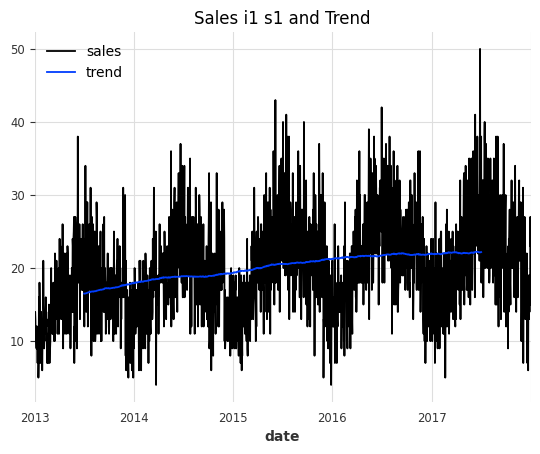

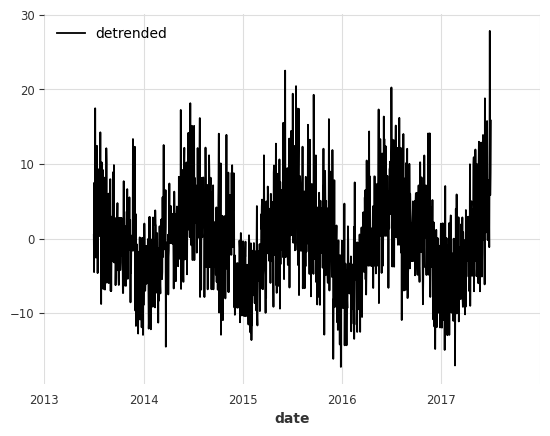

In [136]:
df_i1_s1_additive["trend"] = df_i1_s1_additive["sales"].rolling(window=365, center=True).mean()


df_i1_s1_additive[["sales", "trend"]].plot()
plt.title("Sales i1 s1 and Trend")

df_i1_s1_additive[["detrended"]].plot()

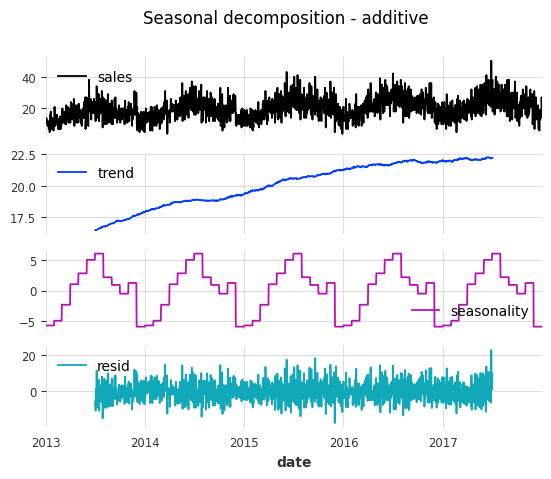

In [137]:
(
    df_i1_s1_additive
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

Видно, що тренд злегка зростає, є річна сезональність, яка має найнижчі продажі у період новорічних свят, пік продаж приблизно літом
Оскільки дані в нас поденні, то розмір викна вибрав 1 рік(365 днів)

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [138]:
pip install darts --quiet

In [139]:
from darts import TimeSeries

series_sales_i1_s1 = TimeSeries.from_dataframe(data_i1_s1, value_cols='sales')

In [140]:
series_sales_i1_s1

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

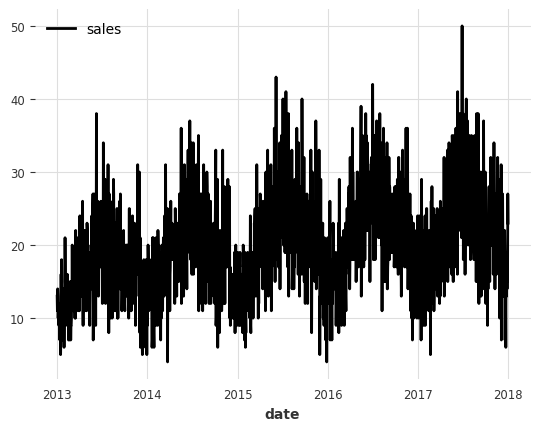

In [141]:
series_sales_i1_s1.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [142]:
series_sales_i1_s1_train, series_sales_i1_s1_val = series_sales_i1_s1.split_before(pd.Timestamp('2017-10-01'))

<Axes: xlabel='date'>

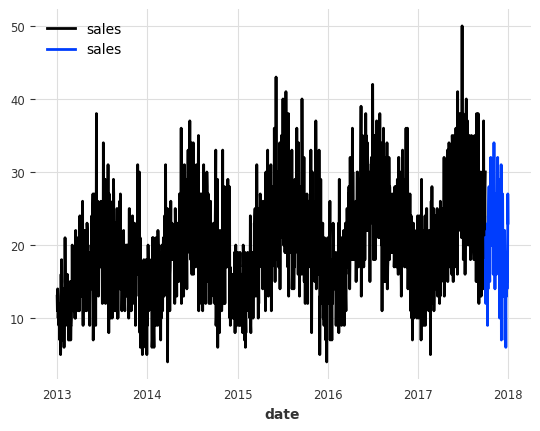

In [143]:
series_sales_i1_s1_train.plot()
series_sales_i1_s1_val.plot()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [144]:
print(type(series_sales_i1_s1))

<class 'darts.timeseries.TimeSeries'>


In [145]:
series_sales_i1_s1

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [146]:
series_sales_i1_s1_pd = series_sales_i1_s1.pd_series()
print(series_sales_i1_s1_pd.head())

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
Freq: D, Name: sales, dtype: float64


<Figure size 1000x600 with 0 Axes>

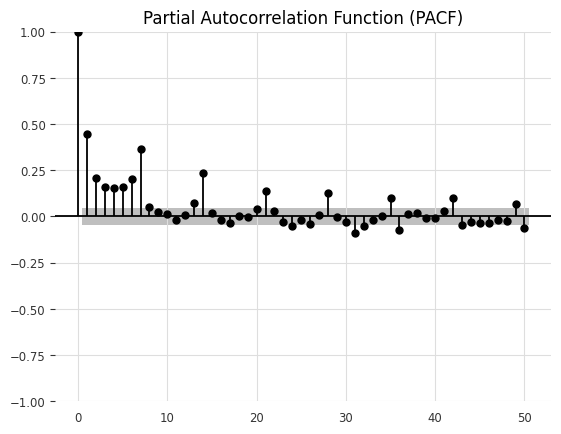

In [147]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(series_sales_i1_s1_pd, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Є сильна автокореляція з першим лагом, що свідчить, що дані сильно корелюють з попереднім значенням.
Також значущі лаги 1-8, 14, 21, 28, 31, 36 та 41.
Потенційно значущі лаги на межі довірчого інтервалу 13 та 49, 50.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [148]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_sales_i1_s1_train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


Сезонність 7

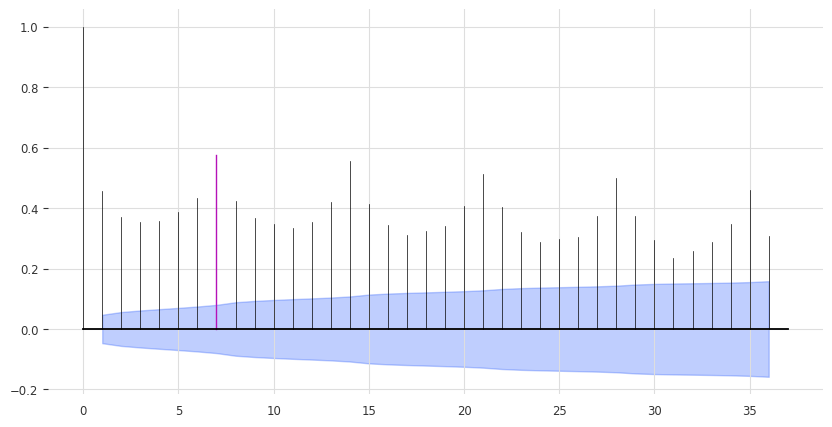

In [149]:
plot_acf(series_sales_i1_s1_train, m=7, alpha=0.05, max_lag=36)

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [150]:
from darts.models import NaiveSeasonal

In [151]:
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-31')
filtered_series_i1_s1 = series_sales_i1_s1.slice(start_date, end_date)

<Axes: xlabel='date'>

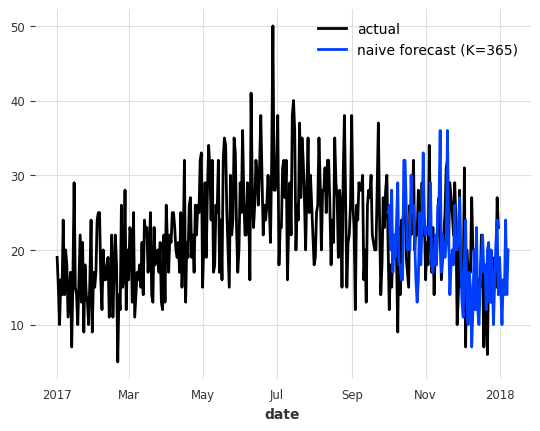

In [152]:
naive_model = NaiveSeasonal(K=365)
naive_model.fit(series_sales_i1_s1_train)
naive_forecast = naive_model.predict(100)

filtered_series_i1_s1.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=365)")

При річній сезонності модель NaiveSeasonal доволі не погано прогнозує на вигляд

<Axes: xlabel='date'>

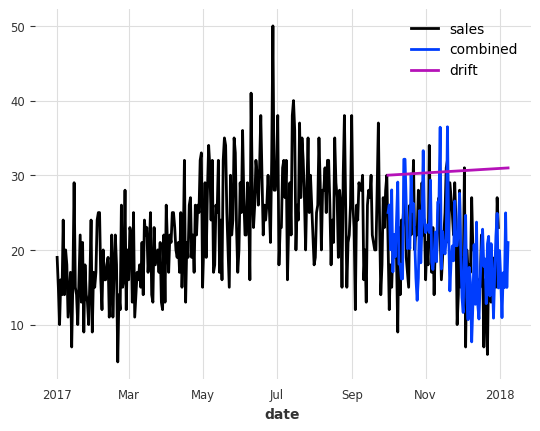

In [153]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(series_sales_i1_s1_train)
drift_forecast = drift_model.predict(100)

combined_forecast = drift_forecast + naive_forecast - series_sales_i1_s1_train.last_value()

filtered_series_i1_s1.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

NaiveDrift взагалі не попадає в передбачення і захопилась загальним трендом

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [154]:
from darts.metrics import mape

In [155]:
print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series_sales_i1_s1_val, combined_forecast):.4f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 34.2589%.


In [156]:
print(
    f"Mean absolute percentage error for the naive drift: {mape(series_sales_i1_s1_val, drift_forecast):.4f}%."
)

Mean absolute percentage error for the naive drift: 68.7441%.


In [157]:
print(
    f"Mean absolute percentage error for the seasonal: {mape(series_sales_i1_s1_val, naive_forecast):.4f}%."
)

Mean absolute percentage error for the seasonal: 33.9227%.


NaiveDrift - дуже велика помилка, погано передбачає
NaiveSeasonal та combined - помилки з не велеикою різницею та всеодно не те, що хотілось би прогнозувати з такою точністю.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [158]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [159]:
def enrich_with_date_features(df):
  # Feature Extraction
  # df["hour"] = df['Month'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  # df["dayofmonth"] = df['Month'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(series_sales_i1_s1_train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(series_sales_i1_s1_val.pd_dataframe().reset_index())

In [160]:
# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(series_sales_i1_s1_train)
val_transformed = scaler.transform(series_sales_i1_s1_val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=365,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=200,  # Кількість дерев у моделі
    max_depth=4,  # Максимальна глибина кожного дерева
    learning_rate=0.05,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(100)
pred.values()

array([[0.5755231 ],
       [0.32587802],
       [0.37846676],
       [0.35064387],
       [0.40680566],
       [0.4586117 ],
       [0.5231859 ],
       [0.5092638 ],
       [0.30425903],
       [0.34187287],
       [0.36969975],
       [0.44417968],
       [0.5036001 ],
       [0.53365505],
       [0.5480739 ],
       [0.32110724],
       [0.3777863 ],
       [0.38515997],
       [0.4360449 ],
       [0.4991322 ],
       [0.4852571 ],
       [0.4937801 ],
       [0.28546202],
       [0.3421841 ],
       [0.35136425],
       [0.42242154],
       [0.4566552 ],
       [0.5453102 ],
       [0.49901924],
       [0.3035766 ],
       [0.38481545],
       [0.3780644 ],
       [0.39078888],
       [0.4233135 ],
       [0.49143398],
       [0.49056917],
       [0.27177608],
       [0.32853672],
       [0.3569506 ],
       [0.38962406],
       [0.50019574],
       [0.4811943 ],
       [0.50301445],
       [0.33194387],
       [0.34653696],
       [0.33757415],
       [0.3716972 ],
       [0.397

In [161]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 100, component: 1, sample: 1)> Size: 400B
array([[[30.47406 ]],

       [[18.990389]],

       [[21.409472]],

       [[20.129618]],

       [[22.71306 ]],

       [[25.096138]],

       [[28.066551]],

       [[27.426134]],

       [[17.995916]],

       [[19.726152]],

...

       [[17.062723]],

       [[23.377298]],

       [[12.388563]],

       [[13.07582 ]],

       [[16.533468]],

       [[16.505428]],

       [[18.067421]],

       [[19.267187]],

       [[21.910398]],

       [[12.246554]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 800B 2017-10-01 2017-10-02 ... 2018-01-08
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

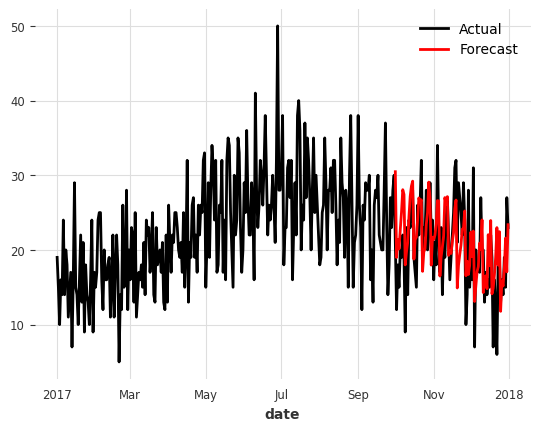

In [162]:
forecast = scaler.inverse_transform(model.predict(len(series_sales_i1_s1_val)))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()


In [163]:
print(
    f"Mean absolute percentage error for the XGBoost: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the XGBoost: 25.4209%.


У попередніх моделях найкращий результат був 33,92, а XGBoost дає 25,42, що вже суттєво краще

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [164]:
def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean absolute percentage error for the ARIMA: 36.3361%.


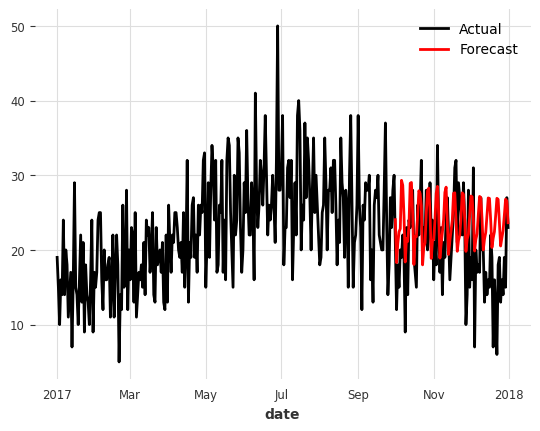

In [165]:
from darts.models import ARIMA

model = ARIMA(p=52, d=1, q=1) # try p=12
model.fit(series_sales_i1_s1_train)
forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the ARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean absolute percentage error for the ARIMA: 39.5282%.


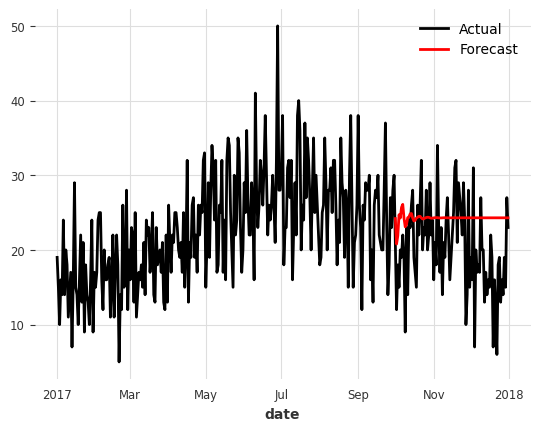

In [166]:
model = ARIMA(p=7, d=1, q=1) # try p=12
model.fit(series_sales_i1_s1_train)
forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the ARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

З параметром р=52 модель краще прогнозує, проте дуже довго виконується обчислення.
З параметром p=7 результати ще гірші
Загалом ARIMA не дуже справляється та не враховує сезонність.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [167]:
from darts.models import AutoARIMA

AutoARIMA(add_encoders=None, start_p=5, max_p=55, start_q=1)

Mean absolute percentage error for the AutoARIMA: 39.5282%.


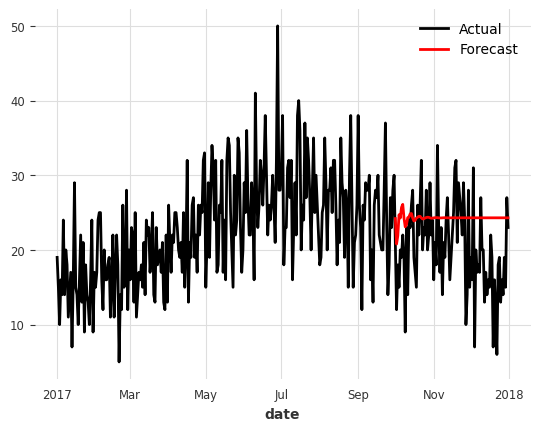

In [168]:
model = AutoARIMA(start_p=5, max_p=55, start_q=1) # спробуйте стартувати з інших значень і перегляньте, що виходить
model.fit(series_sales_i1_s1_train)

display(model)

forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the AutoARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

In [169]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Fri, 16 Aug 2024   AIC                          10591.078
Time:                        10:27:46   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Результат вийшов таким самим як ARIMA(7, 1, 1) що і показало Summary.
Arima просто не підходить під цей випадок TimeSeries.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/87xj3gvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/u_aiynte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44468', 'data', 'file=/tmp/tmpw1uhd3nn/87xj3gvi.json', 'init=/tmp/tmpw1uhd3nn/u_aiynte.json', 'output', 'file=/tmp/tmpw1uhd3nn/prophet_model0pvzabf3/prophet_model-20240816102746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


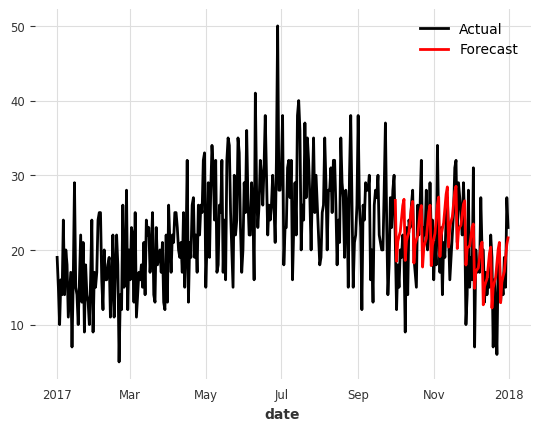

In [170]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(series_sales_i1_s1_train)

# Прогнозування
forecast = model.predict(len(series_sales_i1_s1_val))

# Візуалізація результатів
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [171]:
print(
    f"Mean absolute percentage error for the Prophet: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the Prophet: 23.8048%.


судячи з візуалізації модель досить гарно прогнозує, вловлює тренд, але не вловилює можливість "викидів" чи значень, які вибиваються з тренду.
Поки що Prophet найкраще прогнозкє для цього TimeSeries

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [172]:
from darts.models import RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

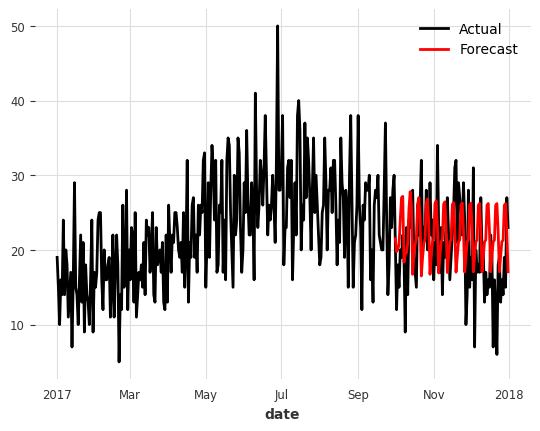

In [173]:
# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=300)
model.fit(series_sales_i1_s1_train)

# Прогнозування
forecast = model.predict(len(series_sales_i1_s1_val))

# Візуалізація результатів
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [174]:
print(
    f"Mean absolute percentage error for the RNNModel: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the RNNModel: 36.7523%.


RNN не дуже спрацювала, не попала у сезонність.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [175]:
model = Prophet()
model.fit(series_sales_i1_s1_train)

forecast = model.predict(len(series_sales_i1_s1_val))

print(
    f"Mean absolute percentage error for the RNNModel: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/tj5pu2r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/gci3pna3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60392', 'data', 'file=/tmp/tmpw1uhd3nn/tj5pu2r3.json', 'init=/tmp/tmpw1uhd3nn/gci3pna3.json', 'output', 'file=/tmp/tmpw1uhd3nn/prophet_model80n7vezj/prophet_model-20240816103830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for the RNNModel: 23.8048%.


In [118]:
?historical_fcast

Object `historical_fcast` not found.


  0%|          | 0/365 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/uc2_70qb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1uhd3nn/kp37r4xu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16624', 'data', 'file=/tmp/tmpw1uhd3nn/uc2_70qb.json', 'init=/tmp/tmpw1uhd3nn/kp37r4xu.json', 'output', 'file=/tmp/tmpw1uhd3nn/prophet_modelm8itjbsw/prophet_model-20240816110656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/365 [00:01<09:30,  1.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet wi

MAPE = 20.56%


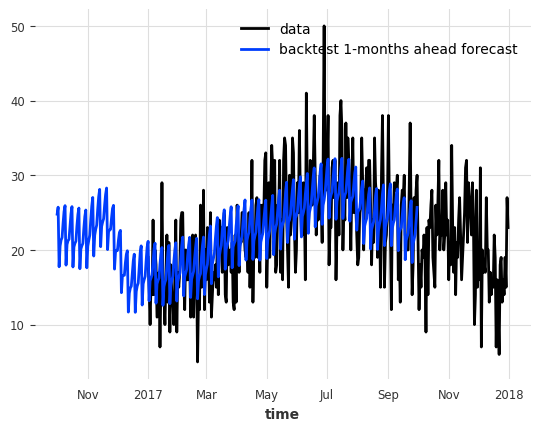

In [179]:
hfc_params = {
    "series": series_sales_i1_s1_train,
    "start": pd.Timestamp("2016-10-01"),
    "forecast_horizon": 1,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

filtered_series_i1_s1.plot(label="data")
historical_fcast.plot(label="backtest 1-months ahead forecast")
print(f"MAPE = {mape(series_sales_i1_s1, historical_fcast):.2f}%")

Вийшло, непогано, попадає у сезонність, трохи недозахоплює варіативність. MAPE покращився і став 20,56 з 25+

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Для вирішення задачі прогнозування у кожному з 10 магазинів на всі 50 товарів спершу я би проаналізував так як у цьому ДЗ спершу один товар. Потім використати візуалізацію продаж по магазинах, як у EDA для розуміння розкиду продаж по магазинно. Застосував би підхід із цього ДЗ для 5 довільних товарів у довільних магазинах і ще по 2 для найпродаваніших товарів у магазинах із найбільшими продажами для розуміння, що одна модель приблизно однаково справляється на кожній вибірці. Тоді циклом прогнати створення data(series) для кожного товару у кожному магазині. Далі використав би модель, наприклад як у випадку ДЗ Prophet з виведенням результатів у таблицю та з'єднанням їх у загальну таблицю для кожного магазину прогноз продаж на місяць.